In [90]:
#importations de bibliothèques 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [46]:
# chargement des deux tables de la base de données
orders_distance_stores_softmax = pd.read_csv("orders_distance_stores_softmax.csv")
orders_products__prior_specials = pd.read_csv("order_products__prior_specials.csv")

In [47]:
orders_distance_stores_softmax

,Unnamed: 0,user_id,store_id,distance,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,210,0,2.30,1438665,prior,9,1,18,3.00
1,1,210,0,2.30,2850206,prior,36,0,7,2.00
2,2,210,0,2.30,2406913,prior,42,0,8,3.00
3,3,210,0,2.30,1155933,prior,43,2,23,2.00
4,4,210,0,2.30,271697,prior,56,5,17,3.00
...,...,...,...,...,...,...,...,...,...,...
136021,136021,206105,9,2.14,1841888,prior,39,0,21,1.00
136022,136022,206105,9,2.14,1137676,prior,43,4,15,1.00
136023,136023,206105,9,2.14,1439511,prior,45,6,9,1.00
136024,136024,206105,9,2.14,1783607,prior,58,4,19,0.00


In [48]:
orders_products__prior_specials

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,special
0,0,15,19660,1,1,15
1,1,15,21195,2,1,0
2,2,15,7461,3,1,50
3,3,15,2996,4,1,0
4,4,15,32463,5,1,0
...,...,...,...,...,...,...
1172307,1172307,3421069,21137,8,1,0
1172308,1172308,3421069,30391,9,1,15
1172309,1172309,3421069,18656,10,1,0
1172310,1172310,3421069,26940,11,1,15


## Concaténation des deux tables

In [49]:
# Obtenir l'ensemble des noms de colonnes uniques
colonnes_uniques = set(orders_distance_stores_softmax.columns).union(set(orders_products__prior_specials.columns))

Pour la concaténation, nous avons utilisé la méthode "merge" en se basant sur l'attribut commun des deux tables "order_id". Nous avons fixé la méthode de jointure à "inner" pour obtenir uniquement les lignes qui ont des correspondances dans les deux tables. 

In [50]:
#combiner les deux tables de la base de données
data = orders_products__prior_specials.merge(orders_distance_stores_softmax, on='order_id', how='inner', suffixes=('', '_dup'))


In [51]:
data.shape

(1172312, 15)

In [52]:
data.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,special,Unnamed: 0_dup,user_id,store_id,distance,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,15,19660,1,1,15,37332,54901,1,0.30,prior,51,3,11,2.00
1,1,15,21195,2,1,0,37332,54901,1,0.30,prior,51,3,11,2.00
2,2,15,7461,3,1,50,37332,54901,1,0.30,prior,51,3,11,2.00
3,3,15,2996,4,1,0,37332,54901,1,0.30,prior,51,3,11,2.00
4,4,15,32463,5,1,0,37332,54901,1,0.30,prior,51,3,11,2.00


Notre ensemble de données contient 1172312 et 15 colonnes dont les colonnes "Unnamed". Nous allons les supprimer (non pertinents pour notre étude).

In [53]:
data = data.drop(columns=['Unnamed: 0', 'Unnamed: 0_dup'])

In [54]:
data.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'special',
       'user_id', 'store_id', 'distance', 'eval_set', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

Nous avons donc 13 attributs donc l'attribut à prédire "reordered". Nous allons afficher le nombre d'échantillons pour chaque classe de l'attribut. Cette information sera pertinente pour l'analyse des résultats de prédiction. En cas de déséquilibre, il faut choisir des métriques spécifiques comme F1.

In [55]:
data['reordered'].value_counts()

1    907879
0    264433
Name: reordered, dtype: int64

## Réduction des données (5%)

Avant de réduire nos données, nous allons les pourcentages des valeurs manquantes pour optimiser notre nouvel sous-ensemble.

In [56]:
# Calcul de la moyenne des valeurs manquantes pour chaque colonne
pourcentage_valeurs_manquantes = (data.isnull().mean() * 100).round(2)

# Convertir le résultat en DataFrame pour une meilleure présentation
tableau_pourcentage_valeurs_manquantes = pd.DataFrame(pourcentage_valeurs_manquantes, columns=['Pourcentage de valeurs manquantes'])

tableau_pourcentage_valeurs_manquantes

,Pourcentage de valeurs manquantes
order_id,0.00
product_id,0.00
add_to_cart_order,0.00
reordered,0.00
special,0.00
user_id,0.00
store_id,0.00
distance,0.00
eval_set,0.00
order_number,0.00


Puisque nous avons plus de 1m de lignes (échantillons), nous nous permettons de supprimer les lignes où la valeur 'days_since_prior_order' est manquante.

In [57]:
# Suppression des lignes où 'days_since_prior_order' est null
data = data.dropna(subset=['days_since_prior_order'])

Pour générer un sous ensemble de 5% des données, nous avons utilisé la méthode "train_test_split". Nous avons fait une stratification par rapport au "user_id" parce que notre prédiction de l'attribut "reordered" concerne aussi l'utilisateur (s'il a refait la même commande) donc nous avons voulu assurer qu'il y a un nombre équilibré et varié des utilisateurs (et leurs commandes).

In [58]:
# stratification avec les IDs des utilisateurs
_, sampled_df = train_test_split(data, test_size=0.05, stratify=data['user_id'], random_state=42)

# Sous ensemble obtenu
print(sampled_df.columns)

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'special',
       'user_id', 'store_id', 'distance', 'eval_set', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')


In [59]:
sampled_df.shape

(57923, 13)

Notre sous-ensemble contient 57923 échantillons et 12 prédicteurs.

In [60]:
#afficher quelques statistiques sur les attributs du sous ensemble obtenu
sampled_stats = sampled_df.describe()
print(sampled_stats)

        order_id  product_id  add_to_cart_order  reordered  special   user_id  \
count   57923.00    57923.00           57923.00   57923.00 57923.00  57923.00   
mean  1713446.33    25550.80               7.30       0.79     9.68 101105.02   
std    988399.76    14045.23               6.64       0.41    14.92  60524.23   
min       128.00        1.00               1.00       0.00     0.00    210.00   
25%    859158.00    13541.00               3.00       1.00     0.00  49186.00   
50%   1716721.00    25133.00               5.00       1.00     0.00  99352.00   
75%   2568789.00    38003.00              10.00       1.00    15.00 154378.00   
max   3421004.00    49683.00              96.00       1.00    50.00 206105.00   

       store_id  distance  order_number  order_dow  order_hour_of_day  \
count  57923.00  57923.00      57923.00   57923.00           57923.00   
mean       4.52      1.26         50.22       2.85              12.99   
std        2.86      0.66         28.79       1.92 

Nous allons vérifier qu'il y a un nombre raisonnable des commandes par utilisateur.

In [61]:
# Calcul de la taille de chaque groupe d'user_id
group_sizes = sampled_df.groupby('user_id').size()

# Tentative d'afficher tous les résultats
print(group_sizes.to_string())

user_id
210        73
310        24
313        39
690        42
786        50
964        36
1024        7
1310       37
1420       27
1428       20
1549       42
1563       96
1666       42
1683       45
1868       47
1958       36
2231       52
2387       31
2405       33
3377       13
3514       24
3742       45
3960       28
4199       35
4229       51
4284       18
4356       72
4382       35
4490       82
4499       42
4558       41
4563       42
4693       68
4711       58
4764       23
4807       31
5003       70
5101       49
5191       47
5199       50
5296       35
5329       31
5449       42
5732       34
5912       29
5932       36
6045       16
6268       55
6398       26
6448       52
6494       36
6710      114
6978       29
7120       31
7175       36
7278       36
7279       70
7385       37
7440       59
7658       24
7744       80
7832       40
8085       42
8086       24
8220       30
8359       76
8365       24
8419       53
8420       47
8664       39
8703       3

## Préparation des données 

Encodage des variables catégorielles (eval_set)

In [62]:
# Initialisation du LabelEncoder
label_encoder = LabelEncoder()

# Identification des colonnes catégorielles
variables_categorielles = sampled_df.select_dtypes(include=['object', 'category']).columns

# Boucle sur chaque colonne catégorielle pour appliquer le LabelEncoder directement sur la colonne originale
for col in variables_categorielles:
    # Application du LabelEncoder à la colonne et écrasement de la colonne originale avec la version encodée
    sampled_df[col] = label_encoder.fit_transform(sampled_df[col])

In [63]:
sampled_df.head

<bound method NDFrame.head of         order_id  product_id  add_to_cart_order  reordered  special  user_id  \
760490   2217474       42265                  5          1       30   110129   
841198   2451110       19364                  2          0       30     5329   
295601    864357        9666                  2          1        0   202153   
236126    692655       39636                 14          1        0     6448   
917938   2676822       14118                  5          1        0    67736   
...          ...         ...                ...        ...      ...      ...   
975389   2842333       22935                  8          1        0   169071   
425960   1246754       27966                  4          1       30    26693   
433160   1267139       38694                  4          1        0   186704   
871074   2539970       16262                  6          1        0    79106   
897310   2615178        7948                  6          1       50   174555   

        s

In [64]:
#catégories pour les attributs de notre ensemble de données
sampled_df.nunique()

order_id                  43983
product_id                 9946
add_to_cart_order            81
reordered                     2
special                       4
user_id                    1374
store_id                     10
distance                  12666
eval_set                      1
order_number                 98
order_dow                     7
order_hour_of_day            24
days_since_prior_order       31
dtype: int64

Nous remarquons que "eval_set" a une seule valeur.

In [65]:
#vérifier que le LabelEncoder a été fonctionnel
sampled_df['eval_set'].dtype

dtype('int32')

Nous allons convertir les valeurs de l'attribut 'order_hour_of_day' pour qu'elles aient la même unité que l'attribut 'days_since_prior_order'. Nous voulons que les deux attributs soient exprimés en jours.

In [66]:
# Convertir les heures en jours (1 jour = 24 heures) pour 'order_hour_of_day'
sampled_df['order_hour_of_day'] = sampled_df['order_hour_of_day'] / 24

## Vérification des valeurs dupliquées

In [67]:
#vérifier qu'il n'y a pas de lignes (échantillons) dubliquées pour notre ensemble de données
duplicates_df = sampled_df[sampled_df.duplicated()]
duplicates_df_sorted = duplicates_df.sort_values(by=['order_id'])
print(f"Nombre de valeurs dupliquées dans nos données \n{duplicates_df_sorted.sum()}")

Nombre de valeurs dupliquées dans nos données 
order_id                 0.00
product_id               0.00
add_to_cart_order        0.00
reordered                0.00
special                  0.00
user_id                  0.00
store_id                 0.00
distance                 0.00
eval_set                 0.00
order_number             0.00
order_dow                0.00
order_hour_of_day        0.00
days_since_prior_order   0.00
dtype: float64


Dans cette partie, nous avons vérifié que nos échantillons ne soient pas dupliqués puisque tous les nombres sont à 0.

## Visualisation des données 

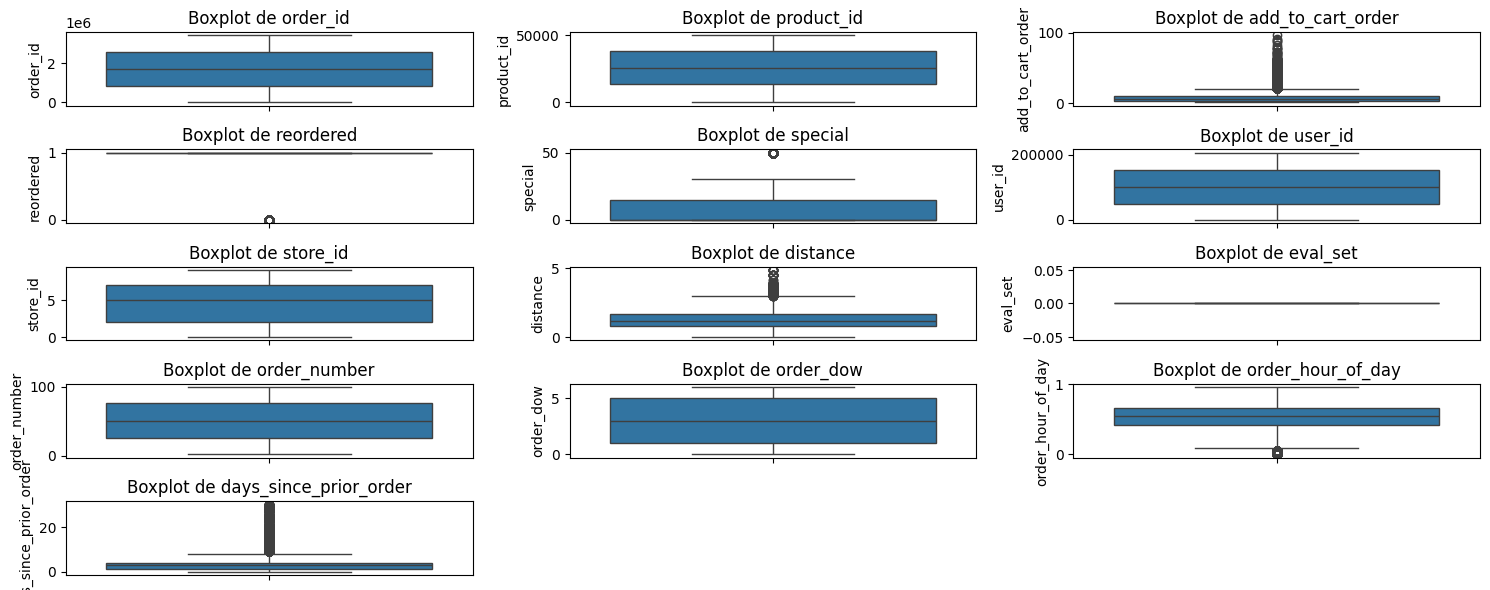

In [68]:
# Sélection des colonnes numériques
colonnes_numeriques = sampled_df.select_dtypes(include=['float64', 'int64', 'int32']).columns

# Définition de la taille de la grille
n_cols = 3
n_rows = int(np.ceil(len(colonnes_numeriques) / n_cols))

# Création des figures de boxplot avec ajustement de la taille
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6))  # Ajuster la largeur et la hauteur selon vos préférences
axes = axes.flatten()

# Traçage des boxplots pour les colonnes numériques
for i, col in enumerate(colonnes_numeriques):
    sns.boxplot(y=sampled_df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_ylabel(col)

# Masquer les axes supplémentaires s'il y en a
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Analyse des visualisations des boxplots : 

Boxplot de store_id : Les identifiants de magasin montrent une certaine variabilité, mais la distribution est centrée, ce qui indique que les commandes proviennent d'un groupe relativement cohérent de magasins.

Boxplot de order_number : Les numéros de commande semblent avoir une distribution étendue avec la médiane vers le bas de la gamme, ce qui pourrait indiquer que de nombreux utilisateurs sont dans les premières étapes de l'historique de commande.

Boxplot de days_since_prior_order : Cette variable a une médiane proche de 0 avec des valeurs étendues vers le haut, ce qui indique des variations dans le temps écoulé depuis la dernière commande.

Boxplot de product_id : Les identifiants de produit sont distribués sur une large gamme avec quelques valeurs aberrantes, ce qui indique une grande variété de produits commandés.

Boxplot de special : Cette variable a une médiane à 0 et quelques valeurs aberrantes, ce qui suggère que des offres spéciales ne sont appliquées que dans un nombre limité de cas.

Boxplot de distance : Il y a des valeurs aberrantes, ce qui indique que bien que la plupart des utilisateurs soient à une distance moyenne des magasins, certains sont nettement plus éloignés.

Boxplot de order_dow : La distribution semble régulière sur toute la semaine sans valeurs aberrantes, suggérant une tendance uniforme dans les jours de passation des commandes.

Boxplot de add_to_cart_order : Il y a une grande variété dans l'ordre d'ajout des produits au panier, avec de nombreuses valeurs aberrantes, ce qui pourrait indiquer que certains produits ont tendance à être ajoutés au panier avant d'autres.

Boxplot de user_id : Les identifiants d'utilisateur ont une large distribution, ce qui suggère une grande base d'utilisateurs.

Boxplot de eval_set : Le boxplot n'est pas informatif ici puisque l'attribut contient une seule valeur.

Boxplot de order_hour_of_day : La distribution des heures de commande est centrée avec quelques valeurs aberrantes, indiquant des moments privilégiés pour passer commande au cours de la journée.

## Feature Engineering 

Dans ce contexte de ce tp, vous souhaitez prédire si un produit sera réordonné (reordered étant la variable cible) dans une future commande en fonction de l'historique d'achat d'un utilisateur. Basé sur cette objectif, voici les attributs que nous pensons ne pas avoir de valeur ajoutée pour la prédiction et donc être des candidats à l'élimination :

- order_id : C'est un identifiant unique pour chaque commande, il n'aide pas directement à prédire le réordonnancement. 

- eval_set : Il s'agit simplement d'une variable technique indiquant l'appartenance des données à un ensemble d'entraînement, de validation ou de test et qui garde la même valeur pour toutes les échantillons de notre ensemble de données. Elle ne doit pas être incluse dans l'entraînement du modèle pour éviter la fuite de données.

- store_id : L'identifiant du magasin n'a pas de relation avec la probabilité de réordonner un produit, cet attribut est à écarter.

L'attribut "user_id" en soi n'est pas une caractéristique prédictive directe, mais il est essentiel pour grouper les données et générer des caractéristiques comportementales significatives au niveau de l'utilisateur qui peuvent grandement améliorer la performance de votre modèle de prédiction.

In [69]:
# Suppression des attributs en question
sampled_df = sampled_df.drop(columns = ['store_id', 'order_id', 'eval_set'])

## Normalisation des données

Cette étape est importante et nécessaire pour l'entraînement de la majorité des modèles de Machine et/ou Deep Learning.

In [70]:
# Préparation des ensembles X et y
X = sampled_df.drop('reordered', axis=1) 
y = sampled_df['reordered']  

# Création de l'objet StandardScaler pour la normalisation
scaler = StandardScaler()

# Ajustement du scaler sur les données puis transformation
X_scaled = scaler.fit_transform(X)

# Convertir X_scaled de nouveau en DataFrame pour garder les noms de colonne
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

## Division des données en ensembles Train et Test

In [71]:
# Séparation des données en ensemble d'entraînement (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [72]:
# Sélection des colonnes numériques pour des visualisations
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

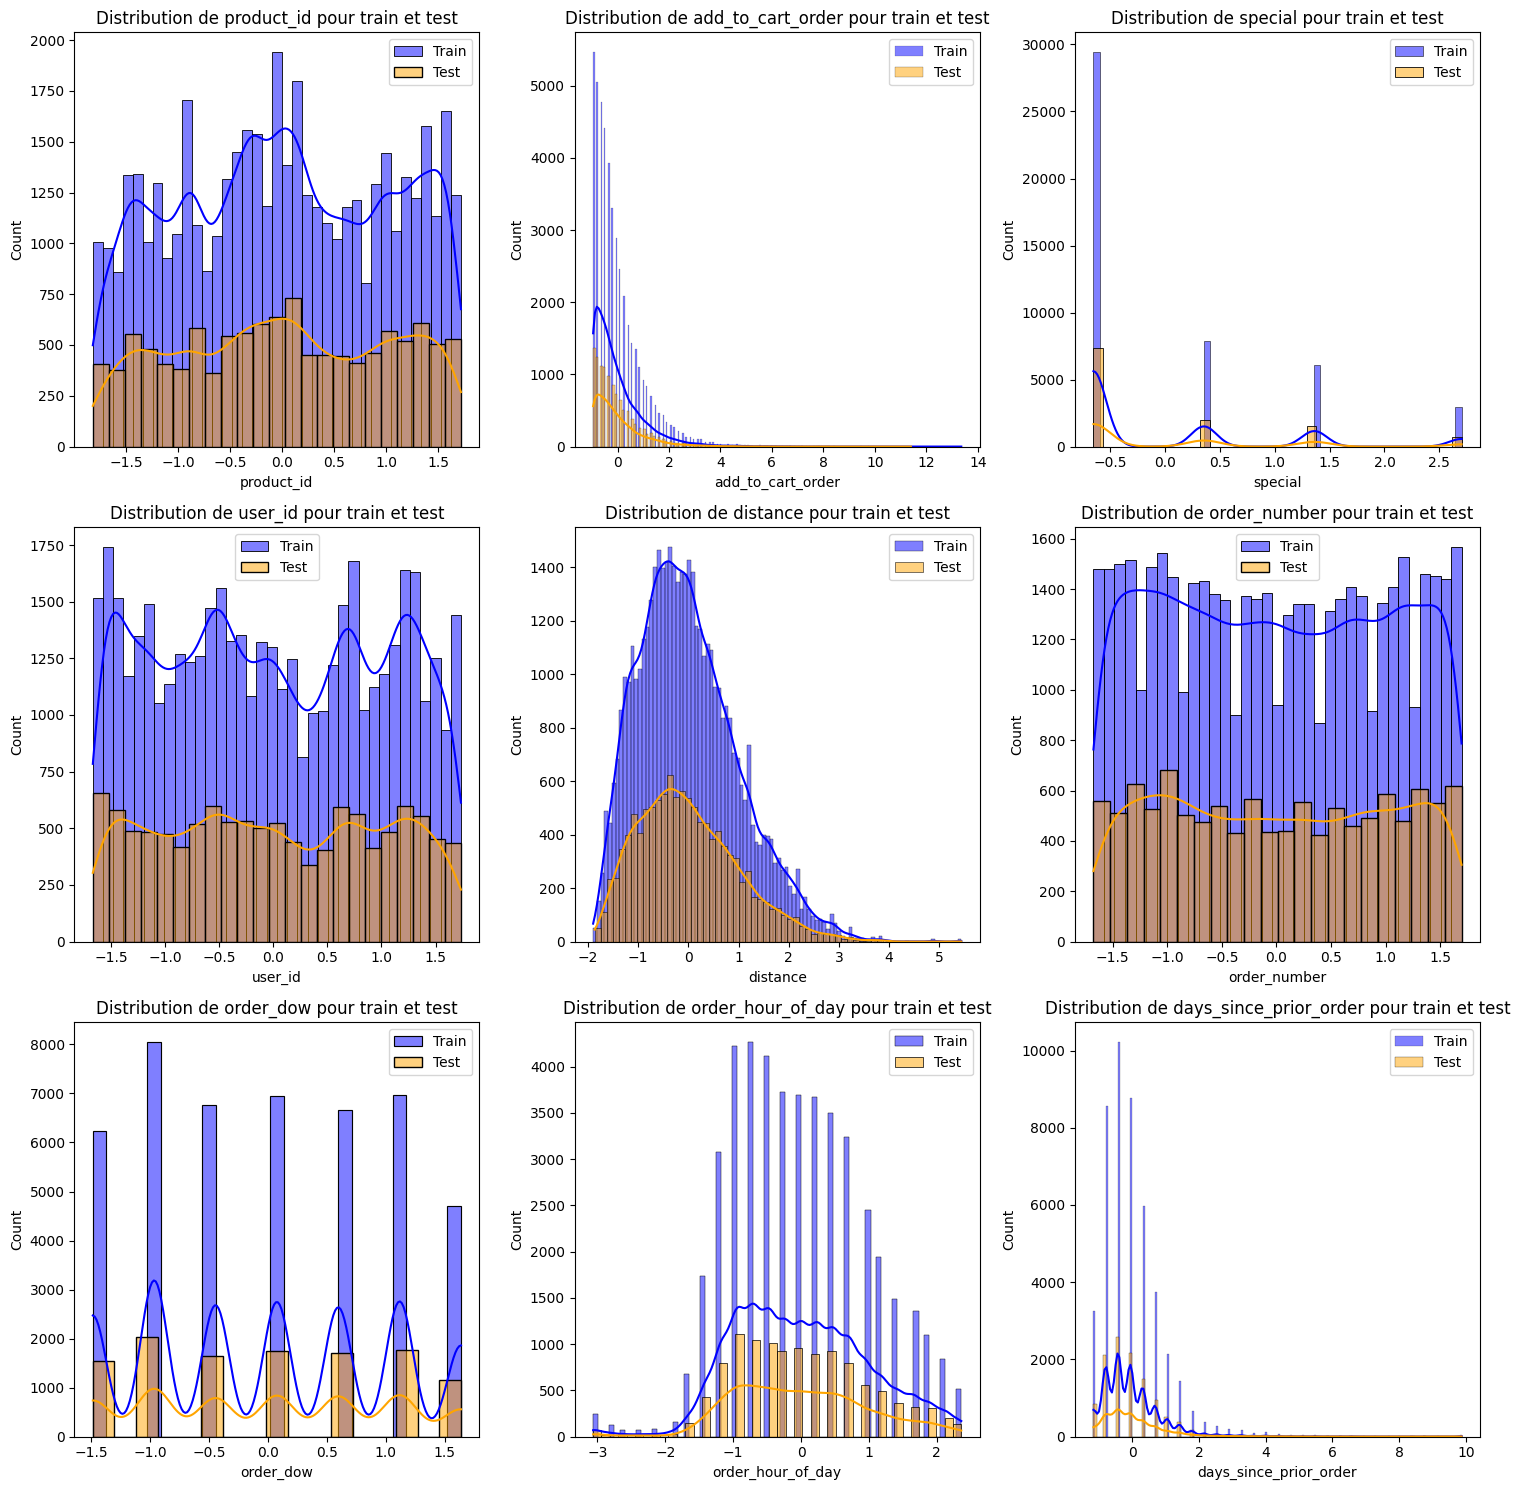

In [73]:
# Réglage des paramètres pour afficher 3 figures par ligne
n_cols = 3  # Nombre de colonnes par ligne dans la grille de subplots
n_rows = int(np.ceil(len(numeric_columns) / n_cols))  # Calcul du nombre de lignes nécessaires

# Création d'une figure et de subplots avec la grille spécifiée
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

# Aplatir le tableau d'axes pour une itération facile si nécessaire
axes_flat = axes.flatten()

# Visualisation avec des histogrammes pour chaque colonne numérique
for i, col in enumerate(numeric_columns):
    sns.histplot(X_train[col], color='blue', label='Train', kde=True, ax=axes_flat[i])
    sns.histplot(X_test[col], color='orange', label='Test', kde=True, ax=axes_flat[i])
    axes_flat[i].set_title(f'Distribution de {col} pour train et test')
    axes_flat[i].legend()

# Si le nombre total de colonnes numériques n'est pas un multiple de 3, masquer les axes vides
for j in range(i+1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout()
plt.show()

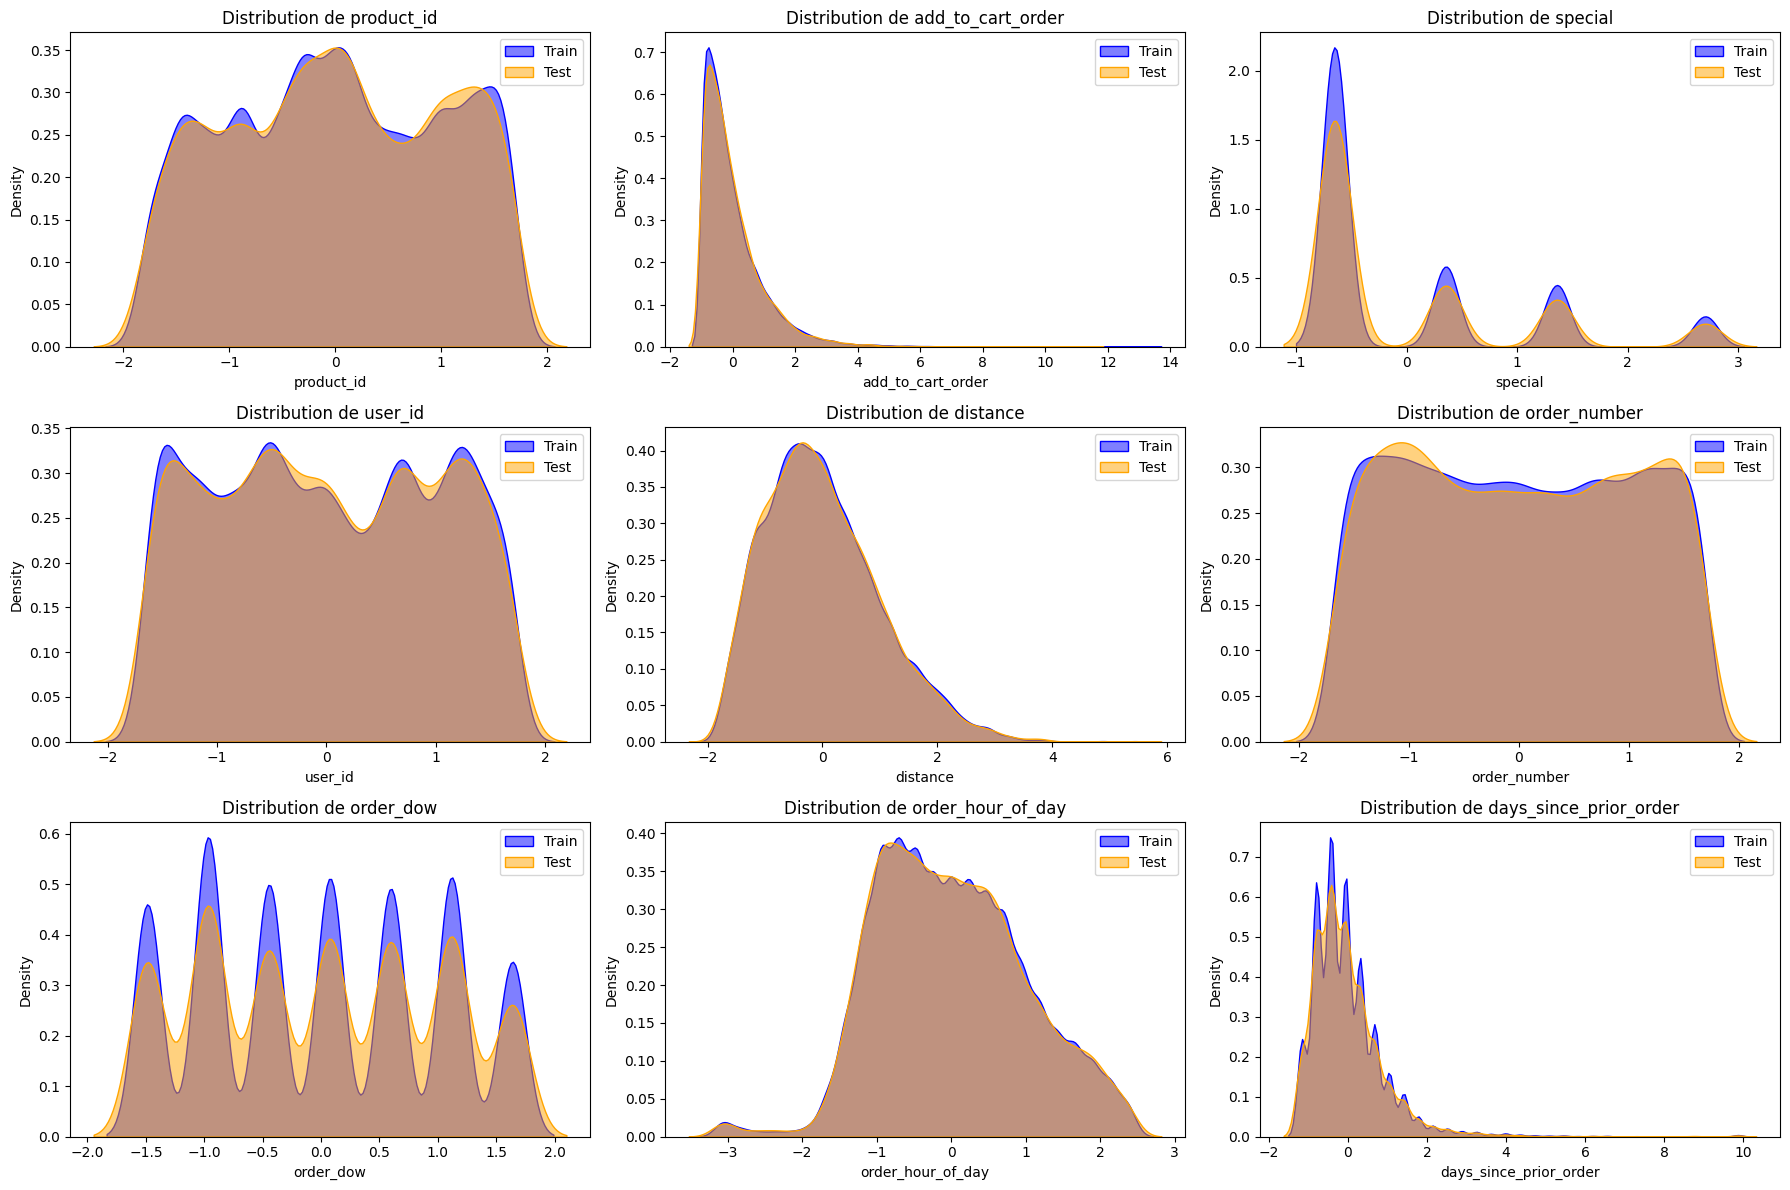

In [74]:
# Création d'une figure avec la grille de subplots pour des courbes de densité
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))

# Parcourir chaque colonne numérique et tracer des courbes de densité pour les ensembles train et test
for i, col in enumerate(numeric_columns):
    row = i // n_cols
    col_index = i % n_cols
    ax = axes[row, col_index]

    # Tracer la courbe de densité pour l'ensemble d'entraînement
    sns.kdeplot(data=X_train, x=col, fill=True, ax=ax, label='Train', color='blue', alpha=0.5)

    # Tracer la courbe de densité pour l'ensemble de test
    sns.kdeplot(data=X_test, x=col, fill=True, ax=ax, label='Test', color='orange', alpha=0.5)

    ax.set_title(f'Distribution de {col}')
    ax.legend()

# Cacher les subplots vides s'il y en a
for j in range(i+1, n_rows*n_cols):
    axes.flat[j].set_visible(False)

plt.tight_layout()
plt.show()

Les courbes montrent que les ensembles d'entraînement et de test ont des distributions cohérentes et comparables pour la majorité des attributs examinées. Cela signifie que la séparation des données a été bien réalisée, offrant ainsi une bonne représentativité et permettant d'anticiper que les modèles de machine learning entraînés sur l'ensemble d'entraînement devraient avoir des performances similaires sur l'ensemble de test. Les pics et creux correspondants dans les courbes de densité de product_id, add_to_cart_order, et days_since_prior_order reflètent des tendances spécifiques de comportement d'achat qui sont préservées entre les ensembles. Les caractéristiques périodiques comme order_dow et les pics d'heures dans order_hour_of_day sont particulièrement remarquables, révélant des schémas d'achat récurrents sur les jours et les heures qui pourraient être significatifs pour la prédiction du réordonnancement. En résumé, ces visualisations fournissent une confirmation visuelle que la séparation des données maintient l'intégrité statistique nécessaire pour une modélisation prédictive fiable.

# Sauvegarde des fichiers

In [75]:
# Pour les données d'entraînement
X_train.to_csv('x_train_final.csv', index=False)
y_train.to_csv('y_train_final.csv', index=False)

# Pour les données de test
X_test.to_csv('x_test_final.csv', index=False)
y_test.to_csv('y_test_final.csv', index=False)

# Pour sample_df
sampled_df.to_csv('final_data_1.csv', index=False)

## Entraînement des modèles (Question 2)

Avant d'entraîner nos données sur des modèles, nous allons voir la distribution des classes de l'attribut à prédire (reordered).

In [76]:
y_train.value_counts()

1    36392
0     9946
Name: reordered, dtype: int64

In [77]:
y_test.value_counts()

1    9099
0    2486
Name: reordered, dtype: int64

Nous avons choisi de ne pas appliquer de méthodes spécifiques pour équilibrer les classes de l'attribut à prédire. Nous traitons un problème de prédiction de re-commande d'un produit donc il est important que nous gardons les tendances telles qu'elles sont sans modification externe.

Implémentation du CNN

In [78]:
# chaque exemple de notre ensemble de données a N caractéristiques
# Remodeler les données pour le CNN 1D
n_features = X_train.shape[1]  # N sera le nombre total de caractéristiques
X_train_reshaped = X_train.values.reshape(-1, n_features, 1)
X_test_reshaped = X_test.values.reshape(-1, n_features, 1)

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Initialiser le modèle séquentiel
model = Sequential()

# Ajouter la première couche convolutive 1D
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_features, 1)))

# Ajouter une deuxième couche convolutive 1D
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))

# Ajouter une autre couche de MaxPooling
model.add(MaxPooling1D(pool_size=2))

# Aplatir les sorties pour les rendre compatibles avec les couches denses
model.add(Flatten())

# Ajouter une couche dense cachée
model.add(Dense(100, activation='relu'))

# Ajouter la couche de sortie
model.add(Dense(1, activation='softmax'))  # Utiliser 'sigmoid' pour la classification binaire

# Afficher le résumé du modèle
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 5, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,761 (198.29 KB)

 Trainable params: 50,761 (198.29 KB)

 Non-trainable params: 0 (0.00 B)

Nous utilisons le score f1 car nous avons des classes non équilibrées et dans ce cas, la précision (accuracy) ne permet pas de capturer la vraie performance du modèle. Et,  car il assure que les modèles doivent bien performer à la fois sur les classes majoritaires et minoritaires pour obtenir un score élevé. 
En effet, dans les jeux de données déséquilibrés, améliorer la précision peut souvent se faire au détriment du rappel, et vice versa. Par exemple, un modèle pourrait prédire très conservativement les cas positifs (pour être sûr à 100% de leur positivité), augmentant ainsi la précision mais réduisant le rappel. Le F1-score, en tant que moyenne harmonique, ne peut être élevé que si les deux, précision et rappel, sont élevés, forçant ainsi le modèle à maintenir un équilibre entre eux.

In [80]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Utiliser 'binary_crossentropy' pour la classification binaire
              metrics=['f1_score'])

In [81]:
# Pour la classification binaire, assurez-vous que y_train et y_test sont binaires (0 ou 1)
# Entrainement du modèle CNN
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2, validation_data=(X_test, y_test))

Epoch 1/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - f1_score: 0.8812 - loss: 0.4586 - val_f1_score: 0.8798 - val_loss: 0.4411
Epoch 2/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - f1_score: 0.8792 - loss: 0.4296 - val_f1_score: 0.8798 - val_loss: 0.4402
Epoch 3/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - f1_score: 0.8786 - loss: 0.4275 - val_f1_score: 0.8798 - val_loss: 0.4348
Epoch 4/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - f1_score: 0.8813 - loss: 0.4182 - val_f1_score: 0.8798 - val_loss: 0.4406
Epoch 5/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - f1_score: 0.8785 - loss: 0.4232 - val_f1_score: 0.8798 - val_loss: 0.4378
Epoch 6/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - f1_score: 0.8816 - loss: 0.4175 - val_f1_score: 0.8798 - val_loss: 0.4342
Epoch 7/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - f1_score: 0.8787 - loss: 0.4207 - val_f1_score: 0.8798 - val_loss: 0.4324
Epoch 8/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - f1_score: 0.8807 - loss: 0.4194 - val_f1_sco

Le modèle a pour f1-score 87,89%. Nous allons faire des tests manuels pour optimiser la performance du modèle CNN. Voir fichier tp2-cnn.ipynb pour plus de détails. Nous avons utilisé un différent fichier pour faire les tests sur CNN parce que ça nécessitait trop de mémoire et c'est plus optimal et intéressant de faire ces calculs sur Colab. Nous avons obtenu le meilleur résultat pour ces valeurs de paramètres : "Filtres: 64, Taille de noyau: 2, Taux de dropout: 0.5, Optimiseur: rmsprop, LR: 0.001 " pour un F1-Score: 0.8859. Nous allons tous de même présenter ces résultats en détails dans la partie suivante.

Le nombre de Filtres est égal à 64. Le nombre de filtres dans une couche convolutive détermine combien de caractéristiques uniques le modèle peut extraire à chaque couche. Un total de 64 filtres permet au modèle de capturer une grande variété de caractéristiques sans être trop complexe, ce qui pourrait mener à un surapprentissage, ni trop simple, ce qui limiterait sa capacité à apprendre des caractéristiques fines des données.

La taille de noyau est égale à 2. La taille du noyau affecte la quantité d'information que le filtre considère à chaque étape de convolution. Une taille de noyau de 2 permet au modèle de détecter des motifs très locaux, ce qui est particulièrement utile pour capter les relations à court terme dans les données, comme les commandes qui se suivent d'un seul client ou les tendances de commandes des clients sur une période précise.

Le taux de dropout est égal à 0.5. Le dropout est une technique de régularisation utilisée pour éviter le surapprentissage en "éteignant" aléatoirement une proportion de neurones durant l'entraînement. Un taux de 0.5 signifie que la moitié des activations sont annulées à chaque mise à jour. Cela force le réseau à apprendre des caractéristiques robustes en utilisant seulement une fraction des neurones, améliorant ainsi la généralisation.

L'optimiseur optimal est RMSprop. Il ajuste le taux d'apprentissage de manière adaptative pour chaque paramètre. Il est particulièrement efficace pour naviguer dans des paysages de gradients complexes et pour des problèmes où le gradient peut changer de manière abrupte, ce qui le rend bien adapté à de nombreux types de données de CNN.

LR (Learning Rate) est égal à 0.001. Le taux d'apprentissage détermine la taille des pas que l'optimiseur prend dans le paysage des gradients. Un taux de 0.001 est suffisamment petit pour permettre des ajustements précis dans les poids du modèle sans sauter par-dessus des minima locaux, mais assez grand pour assurer une convergence rapide. Ce taux est souvent choisi comme point de départ pour de nombreux types de réseaux neuronaux.

In [88]:
pip install lazypredict

Note: you may need to restart the kernel to use updated packages.


## Entraînement de modèles Machine Learning

Résultat préliminaire avec la bibliothèque LazyPredict.

In [89]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

# Initialisation de LazyClassifier pour comparer les modèles de classification
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Affichage des scores F1 des modèles
print(models['F1 Score'])

 97%|█████████▋| 28/29 [38:39<00:20, 20.92s/it]   

[LightGBM] [Info] Number of positive: 36392, number of negative: 9946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 46338, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.785360 -> initscore=1.297179
[LightGBM] [Info] Start training from score 1.297179


100%|██████████| 29/29 [38:40<00:00, 80.02s/it]

Model
NearestCentroid                 0.77
PassiveAggressiveClassifier     0.71
Perceptron                      0.77
BaggingClassifier               0.77
XGBClassifier                   0.78
LGBMClassifier                  0.79
RandomForestClassifier          0.78
ExtraTreesClassifier            0.78
LinearDiscriminantAnalysis      0.78
QuadraticDiscriminantAnalysis   0.78
GaussianNB                      0.78
AdaBoostClassifier              0.78
CalibratedClassifierCV          0.77
ExtraTreeClassifier             0.74
LogisticRegression              0.77
DecisionTreeClassifier          0.73
LabelPropagation                0.74
LinearSVC                       0.77
RidgeClassifier                 0.77
RidgeClassifierCV               0.77
KNeighborsClassifier            0.76
SVC                             0.76
BernoulliNB                     0.74
SGDClassifier                   0.69
DummyClassifier                 0.69
Name: F1 Score, dtype: float64


Nous remarquons que les F1-scores sont assez proches. Le LGBM (Light Gradient Boosting Model) est le modèle le plus performant avec 0.79 de f1-score. Il est suivi par plusieurs modèles ayant comme f1-score 0.78. Nous allons en choisir quelques uns pour les optimiser avec GridSearchCV. Pour cela, nous allons travailler sur les modèles LGBMClassifier, AdaBoostClassifier, LinearDiscriminantAnalysis et RandomForestClassifier. Lazypredict permet en effet d'avoir des résultats préliminaires sur une multitude de modèles de Machine Learning (utilisant plusieurs techniques comme le Bagging, Boosting et autres techniques d'apprentissage). 
Nous allons tout de même commencer par optimiser le modèle SVM puisque c'est demandé dans l'énoncé.

## SVM

In [91]:
#Différentes valeurs pour différents hyperparamètres du modèle SVM
param_grid = {
    'C': [0.1, 1, 10, 100],  # Plus C est élevé, moins la régularisation est forte
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']  # différents noyaux
}

svc = SVC()  # Initialiser le modèle SVM

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, refit=True, verbose=2, cv=5)

In [92]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.5min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.1min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.1min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.1min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 2.0min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=  23.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time= 1.1min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time= 1.2min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time= 1.2min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time= 1.2min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  37.5s
[CV] END .......................C=0.1, gamma=0.

In [ ]:
print(f"Meilleurs paramètres: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Prédiction et rapport de classification sur l'ensemble de test
predictions = best_model.predict(X_test)
print(classification_report(y_test, predictions))